Our solver will solve the Navier Stokes equations in two dimensions to calculate the velocities at each grid point and then move to the next time step. The continuity equation will be used as a governing equation for pressure by some manipulation. Hence the we will solve the following equations in theory:
\begin{equation}
    \cfrac{\partial u}{\partial x} +\cfrac{\partial v}{\partial y}=0
\end{equation}
\begin{equation}
    \frac{\partial u}{\partial t}+u\frac{\partial u}{\partial x}+v\frac{\partial u}{\partial y} = -\frac{1}{\rho}\frac{\partial p}{\partial x}+\nu \left(\frac{\partial^2 u}{\partial x^2}+\frac{\partial^2 u}{\partial y^2} \right)
\end{equation}
\begin{equation}
    \frac{\partial v}{\partial t}+u\frac{\partial v}{\partial x}+v\frac{\partial v}{\partial y} = -\frac{1}{\rho}\frac{\partial p}{\partial y}+\nu\left(\frac{\partial^2 v}{\partial x^2}+\frac{\partial^2 v}{\partial y^2}\right) 
\end{equation}

But since we do not have an explicit governing equation for pressure, we will take the divergence of the momentum equations, add them and use the continuity equation to eliminate the $\cfrac{\partial u}{\partial x} +\cfrac{\partial v}{\partial y}$ terms in the equations, to get the pressure poisson equation, given by,

\begin{equation}
    \frac{\partial^2 p}{\partial x^2}+\frac{\partial^2 p}{\partial y^2} = -\rho\left(\frac{\partial u}{\partial x}\frac{\partial u}{\partial x}+2\frac{\partial u}{\partial y}\frac{\partial v}{\partial x}+\frac{\partial v}{\partial y}\frac{\partial v}{\partial y} \right)
\end{equation}

This equation essentially ensures that continuity is satisfied at the current time step and also couples the pressure and velocities together. 


## Constants and initial conditions

In [8]:
import numpy as np
from matplotlib import pyplot as plt, cm
%matplotlib inline

lx = 5      #length in the x direction
ly = 5      #length in the y direction
nx = 101     #grid points in x direction
ny = 101     #grid points in y direction
t = 1       #final time to calculate to
nit = 10    #pseudo-time steps in each timestep
dx = lx / (nx - 1)
dy = ly / (ny - 1)
x = np.linspace(0, lx, nx)
y = np.linspace(0, ly, ny)
X, Y = np.meshgrid(x, y)

rho = 1
nu = 0.5
dt = .0001 #time step size

nt=int(t/dt)

u = np.zeros((ny, nx)) #initial conditions 
v = np.zeros((ny, nx))
p = np.zeros((ny, nx)) 
#b = np.zeros((ny, nx))

## Function for calculations of pressure poisson equation

In [9]:
def pressure_poisson(p, dx, dy, rho, dt, u, v):
    pn = np.empty_like(p)
    pn = p.copy()
    
    for q in range(nit):
        pn = p.copy()
        p[1:-1, 1:-1] = (((pn[1:-1, 2:] + pn[1:-1, 0:-2]) * dy**2 + 
                          (pn[2:, 1:-1] + pn[0:-2, 1:-1]) * dx**2) /
                          (2 * (dx**2 + dy**2)) -
                          dx**2 * dy**2 / (2 * (dx**2 + dy**2)) * ((rho * (1 / dt * 
                    ((u[1:-1, 2:] - u[1:-1, 0:-2]) / 
                     (2 * dx) + (v[2:, 1:-1] - v[0:-2, 1:-1]) / (2 * dy)) -
                    ((u[1:-1, 2:] - u[1:-1, 0:-2]) / (2 * dx))**2 -
                      2 * ((u[2:, 1:-1] - u[0:-2, 1:-1]) / (2 * dy) *
                           (v[1:-1, 2:] - v[1:-1, 0:-2]) / (2 * dx))-
                          ((v[2:, 1:-1] - v[0:-2, 1:-1]) / (2 * dy))**2))))

        p[:, -1] = p[:, -2] # dp/dx = 0 at right  #pressure BCS
        p[0, :] = p[1, :]   # dp/dy = 0 at bottom
        p[:, 0] = p[:, 1]   # dp/dx = 0 at left
        p[-1, :] = 0        # p = 0 at top
        
    return p

## Functions that solve the momentum equations

In [10]:
def flow_solver(nt, u, v, dt, dx, dy, p, rho, nu):
    un = np.empty_like(u)
    vn = np.empty_like(v)
    
    for n in range(nt):
        un = u.copy()
        vn = v.copy()
        
        p = pressure_poisson(p, dx, dy, rho, dt, u, v)
        
        u[1:-1, 1:-1] = (un[1:-1, 1:-1]-
                         un[1:-1, 1:-1] * dt / dx *
                        (un[1:-1, 1:-1] - un[1:-1, 0:-2]) -
                         vn[1:-1, 1:-1] * dt / dy *
                        (un[1:-1, 1:-1] - un[0:-2, 1:-1]) -
                         dt / (2 * rho * dx) * (p[1:-1, 2:] - p[1:-1, 0:-2]) +
                         nu * (dt / dx**2 *
                        (un[1:-1, 2:] - 2 * un[1:-1, 1:-1] + un[1:-1, 0:-2]) +
                         dt / dy**2 *
                        (un[2:, 1:-1] - 2 * un[1:-1, 1:-1] + un[0:-2, 1:-1])))

        v[1:-1,1:-1] = (vn[1:-1, 1:-1] -
                        un[1:-1, 1:-1] * dt / dx *
                       (vn[1:-1, 1:-1] - vn[1:-1, 0:-2]) -
                        vn[1:-1, 1:-1] * dt / dy *
                       (vn[1:-1, 1:-1] - vn[0:-2, 1:-1]) -
                        dt / (2 * rho * dy) * (p[2:, 1:-1] - p[0:-2, 1:-1]) +
                        nu * (dt / dx**2 *
                       (vn[1:-1, 2:] - 2 * vn[1:-1, 1:-1] + vn[1:-1, 0:-2]) +
                        dt / dy**2 *
                       (vn[2:, 1:-1] - 2 * vn[1:-1, 1:-1] + vn[0:-2, 1:-1])))
        
        #boundary conditions for u
        u[0, :]  = 0    #bottom
        u[-1, :] = 10    #top
        u[:, 0]  = 0    #left
        u[:, -1] = 0    #right
        #boundary conditions for v
        v[0, :]  = 0    #same as u
        v[-1, :] = 0
        v[:, 0]  = 0
        v[:, -1] = 0
        
        
    return u, v, p

In [11]:
u = np.zeros((ny, nx)) #comment out these lines if you want to run from last time step
v = np.zeros((ny, nx))
p = np.zeros((ny, nx))

u, v, p = flow_solver(nt, u, v, dt, dx, dy, p, rho, nu)

vel_mag=(u**2+v**2)**0.5

## Plotting the results

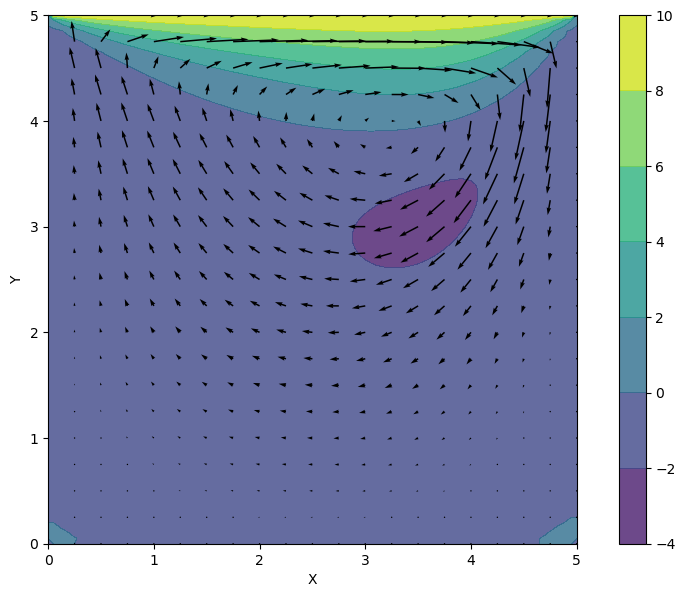

In [17]:
fig = plt.figure(figsize=(11,7),dpi=100)
# plotting the pressure field as a contour
plt.contourf(X, Y, u, alpha=0.8, cmap=cm.viridis)  
plt.colorbar()
## plotting the pressure field outlines
#plt.contour(X, Y, p, cmap=cm.viridis)  
## plotting velocity field
plt.quiver(X[::lx, ::ly], Y[::lx, ::ly], u[::lx, ::ly], v[::lx, ::ly]) 
plt.xlabel('X')
plt.ylabel('Y')
ax = plt.gca()
ax.set_aspect(1)
plt.show()

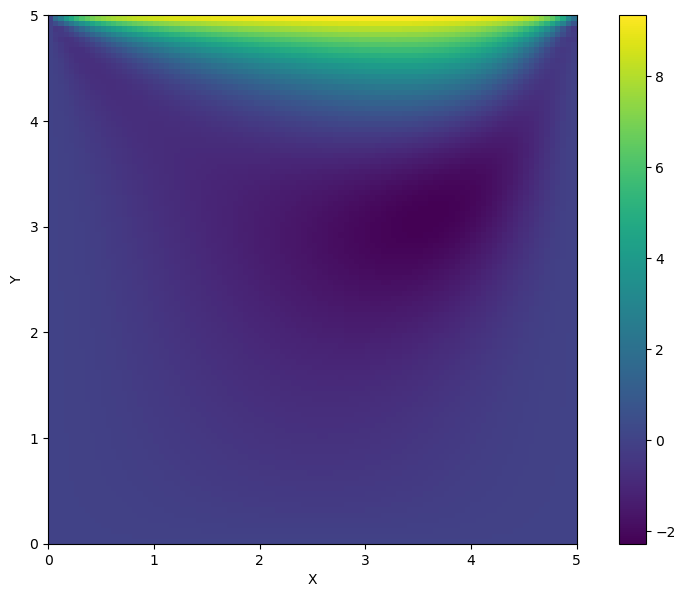

In [15]:
fig = plt.figure(figsize=(11,7),dpi=100)
# plotting the pressure field as a contour
#plt.contourf(X, Y, u, alpha=0.8, cmap=cm.viridis)
## plotting the pressure field outlines
plt.pcolormesh(X, Y, u, alpha=1, cmap=cm.viridis)
plt.colorbar()
## plotting velocity field
#plt.streamplot(X[::lx, ::2*ly], Y[::lx, ::2*ly], u[::lx, ::2*ly], v[::lx, ::2*ly])
plt.xlabel('X')
plt.ylabel('Y')
ax = plt.gca()
ax.set_aspect(1)
plt.show()